In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import ConfusionMatrixDisplay

# DATA

In [2]:
dfct = pd.read_csv('healthcare_clean_transf_data.csv') #dff.copy()
dfct.head()

,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,...,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
0,1,1,2,1,4,3,5,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,4,0,5,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,2,0,0,1,5,0,1,0,...,0,1,0,0,0,0,0,0,0,2
3,0,0,2,1,0,3,5,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,2,1,0,3,5,0,1,1,...,0,0,0,0,0,0,0,0,0,1


In [3]:
X = dfct.drop('Persistency_Flag', axis=1)
y = dfct['Persistency_Flag']

[05:15:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


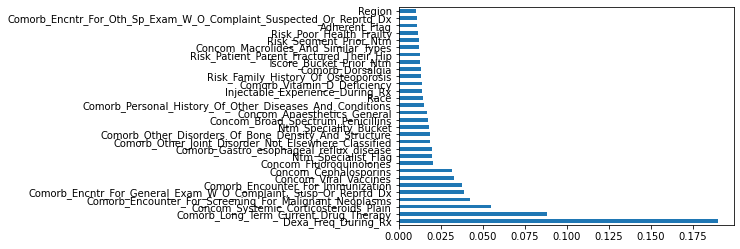

In [5]:
model = XGBRegressor()
model.fit(X, y)

(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(30)
   .plot(kind='barh'))

In [6]:
len(X.columns)

63

In [17]:
bestparams = pd.Series(model.feature_importances_, index=X.columns).nlargest(35).index.to_list()

In [18]:
X = dfct[bestparams]
y = dfct['Persistency_Flag']

In [19]:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.20, random_state=42)

In [32]:
cv = KFold(n_splits=5, shuffle=True)

# Models

## Dummy

In [102]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy="most_frequent")

dummy_classifier.fit(X_train, y_train)
y_pred_dm= dummy_classifier.predict(X_test)

accuracy_score(y_test, y_pred_dm)

0.7111486486486487

In [103]:
print(classification_report(y_test, y_pred_dm))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83       421
           1       0.00      0.00      0.00       171

    accuracy                           0.71       592
   macro avg       0.36      0.50      0.42       592
weighted avg       0.51      0.71      0.59       592



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


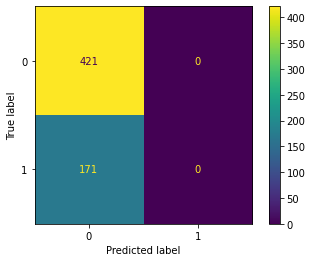

In [104]:
_ = ConfusionMatrixDisplay.from_estimator(dummy_classifier, X_test, y_test)

## Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

lgr= LogisticRegression(solver="liblinear")
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

n_iter_search = 30
random_search = RandomizedSearchCV(lgr, param_distributions=grid,
                                   n_iter=n_iter_search,n_jobs=-1, cv=cv)
random_search.fit(X_train,y_train)
bestp_lgr = random_search.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 14 is smaller than n_iter=30. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


In [43]:
lgr= LogisticRegression(solver="liblinear", **bestp_lgr)
lgr.fit(X_train, y_train)
y_pred_lgr= lgr.predict(X_test)

In [46]:
accuracy_score(y_test, y_pred_lgr)

0.7905405405405406

In [47]:
print(classification_report(y_test, y_pred_lgr))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       421
           1       0.67      0.53      0.59       171

    accuracy                           0.79       592
   macro avg       0.75      0.71      0.73       592
weighted avg       0.78      0.79      0.78       592



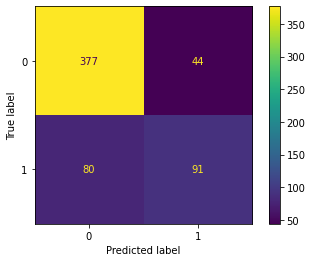

In [90]:
_ = ConfusionMatrixDisplay.from_estimator(lgr, X_test, y_test)

## Support Vector Machine


In [52]:
from sklearn.svm import SVC

svc= SVC()

param_grid = {"C": np.arange(2, 10, 2),
             "gamma": np.arange(0.1, 10, 0.2),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

n_iter_search = 30
random_search = RandomizedSearchCV(svc, param_distributions=param_grid,
                                   n_iter=n_iter_search,n_jobs=-1, cv=cv)
random_search.fit(X_train,y_train)
bestp_svc = random_search.best_params_

In [53]:
svc= SVC(**bestp_svc)
svc.fit(X_train, y_train)
y_pred_svc= svc.predict(X_test)

In [54]:
accuracy_score(y_test, y_pred_svc)

0.8006756756756757

In [55]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.83      0.90      0.87       421
           1       0.69      0.56      0.62       171

    accuracy                           0.80       592
   macro avg       0.76      0.73      0.74       592
weighted avg       0.79      0.80      0.79       592



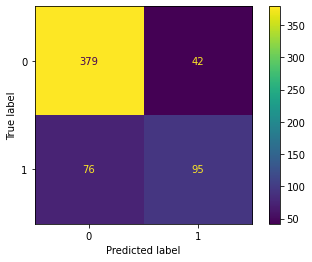

In [91]:
_ = ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test)

## KNN

In [56]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

n_iter_search = 30
random_search = RandomizedSearchCV(knn, param_distributions=param_grid,
                                   n_iter=n_iter_search,n_jobs=-1, cv=cv)
random_search.fit(X_train,y_train)
bestp_knn = random_search.best_params_

In [58]:
knn= KNeighborsClassifier(**bestp_knn)
knn.fit(X_train, y_train)
y_pred_knn= knn.predict(X_test)

In [59]:
accuracy_score(y_test, y_pred_knn)

0.8023648648648649

In [60]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87       421
           1       0.79      0.43      0.56       171

    accuracy                           0.80       592
   macro avg       0.80      0.69      0.71       592
weighted avg       0.80      0.80      0.78       592



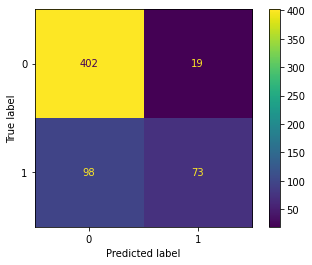

In [92]:
_ = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test)

## RandomForest

In [61]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50, n_jobs=2, random_state=0)
rf.fit(X_train, y_train)
y_pred_rf= knn.predict(X_test)

In [62]:
accuracy_score(y_test, y_pred_rf)

0.8023648648648649

In [63]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87       421
           1       0.79      0.43      0.56       171

    accuracy                           0.80       592
   macro avg       0.80      0.69      0.71       592
weighted avg       0.80      0.80      0.78       592



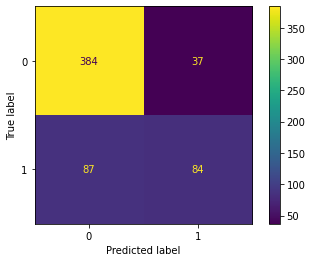

In [93]:
_ = ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)

## SGDClassifier

In [64]:
from sklearn.linear_model import SGDClassifier
from sklearn.utils.fixes import loguniform
import scipy.stats as stats

clf = SGDClassifier(loss='hinge',fit_intercept=True)
param_dist = {'average': [True, False],
              'l1_ratio': stats.uniform(0, 1),
              'alpha': loguniform(1e-4, 1e0)}

n_iter_search = 30
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search,n_jobs=-1, cv=cv)
random_search.fit(X_train,y_train)
bestp_clf = random_search.best_params_

In [66]:
clf = SGDClassifier(**bestp_clf)
clf.fit(X_train, y_train)
y_pred_clf= clf.predict(X_test)

In [67]:
accuracy_score(y_test, y_pred_clf)

0.785472972972973

In [68]:
print(classification_report(y_test, y_pred_clf))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       421
           1       0.66      0.53      0.59       171

    accuracy                           0.79       592
   macro avg       0.74      0.71      0.72       592
weighted avg       0.78      0.79      0.78       592



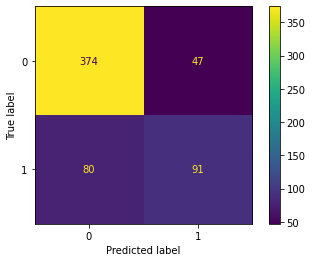

In [94]:
_ = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

## Hist Gradient Boosting

In [79]:
HistGradientBoostingClassifier.get_params().keys()

dict_keys(['categorical_features', 'early_stopping', 'l2_regularization', 'learning_rate', 'loss', 'max_bins', 'max_depth', 'max_iter', 'max_leaf_nodes', 'min_samples_leaf', 'monotonic_cst', 'n_iter_no_change', 'random_state', 'scoring', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [81]:
from sklearn.ensemble import HistGradientBoostingClassifier

histogram_gradient_boosting = HistGradientBoostingClassifier()

parameters = {
 'max_iter': [1000,1200,1500],
 'learning_rate': [0.1,0.001,1],
 'max_depth' : [15, 25, 50, 75],
 'l2_regularization': [0,1.5],
 'scoring': ['f1_micro'],
 }

hgb_grid = GridSearchCV(histogram_gradient_boosting, parameters, n_jobs=-1, 
 cv=cv, verbose=2, refit=True)
 
hgb_grid.fit(X_train, y_train)

bestp_hg = hgb_grid.best_params_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [82]:
hgb_grid = HistGradientBoostingClassifier(**bestp_hg)
hgb_grid.fit(X_train, y_train)
y_pred_histogram_gradient_boosting= hgb_grid.predict(X_test)

In [83]:
accuracy_score(y_test, y_pred_histogram_gradient_boosting)

0.7956081081081081

In [84]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87       421
           1       0.79      0.43      0.56       171

    accuracy                           0.80       592
   macro avg       0.80      0.69      0.71       592
weighted avg       0.80      0.80      0.78       592



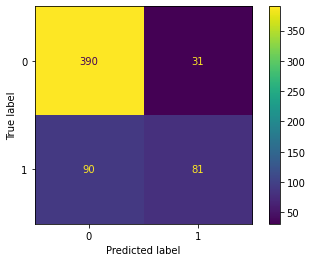

In [95]:
_ = ConfusionMatrixDisplay.from_estimator(hgb_grid, X_test, y_test)

# Best Model

In [85]:
models=[lgr, knn, svc, rf, clf, hgb_grid]

In [97]:
results = pd.DataFrame()   
results.empty

for model in models:
    names=model.__class__.__name__
    y_pred=model.predict(X_test)
    accuracy=accuracy_score(y_test, y_pred)
    result=pd.DataFrame([[names, accuracy*100]], columns=["models", "accuracy"])
    results=results.append(result)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Comparison of Models')

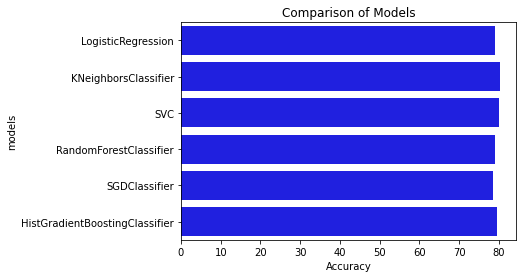

In [98]:
sns.barplot("accuracy", "models", data=results, color="b")
plt.xlabel("Accuracy")
plt.title("Comparison of Models")

# Metrics

## ROC

<Figure size 1080x720 with 0 Axes>

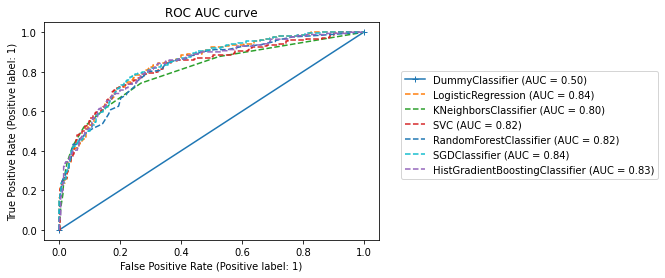

In [111]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, roc_auc_score

disp = RocCurveDisplay.from_estimator(
    dummy_classifier, X_test, y_test, pos_label=1,
    marker="+")
disp = RocCurveDisplay.from_estimator(
    lgr, X_test, y_test, pos_label=1,
    color="tab:orange", linestyle="--", ax=disp.ax_)
disp = RocCurveDisplay.from_estimator(
    knn, X_test, y_test, pos_label=1,
    color="tab:green", linestyle="--", ax=disp.ax_)
disp = RocCurveDisplay.from_estimator(
    svc, X_test, y_test, pos_label=1,
    color="tab:red", linestyle="--", ax=disp.ax_)
disp = RocCurveDisplay.from_estimator(
    rf, X_test, y_test, pos_label=1,
    color="tab:blue", linestyle="--", ax=disp.ax_)
disp = RocCurveDisplay.from_estimator(
    clf, X_test, y_test, pos_label=1,
    color="tab:cyan", linestyle="--", ax=disp.ax_)
disp = RocCurveDisplay.from_estimator(
    hgb_grid, X_test, y_test, pos_label=1,
    color="tab:purple", linestyle="--", ax=disp.ax_)

plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = disp.ax_.set_title("ROC AUC curve")

## Recall

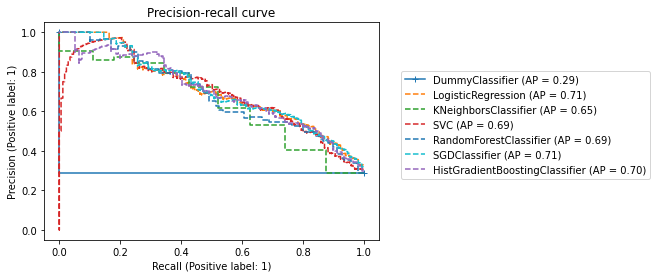

In [112]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_score, recall_score

disp = PrecisionRecallDisplay.from_estimator(
    dummy_classifier, X_test, y_test, pos_label=1,
    marker="+")
disp = PrecisionRecallDisplay.from_estimator(
    lgr, X_test, y_test, pos_label=1,
    color="tab:orange", linestyle="--", ax=disp.ax_)
disp = PrecisionRecallDisplay.from_estimator(
    knn, X_test, y_test, pos_label=1,
    color="tab:green", linestyle="--", ax=disp.ax_)
disp = PrecisionRecallDisplay.from_estimator(
    svc, X_test, y_test, pos_label=1,
    color="tab:red", linestyle="--", ax=disp.ax_)
disp = PrecisionRecallDisplay.from_estimator(
    rf, X_test, y_test, pos_label=1,
    color="tab:blue", linestyle="--", ax=disp.ax_)
disp = PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, pos_label=1,
    color="tab:cyan", linestyle="--", ax=disp.ax_)
disp = PrecisionRecallDisplay.from_estimator(
    hgb_grid, X_test, y_test, pos_label=1,
    color="tab:purple", linestyle="--", ax=disp.ax_)


plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = disp.ax_.set_title("Precision-recall curve")

END!